# Advanced Machine Learning
# Exercise 5 – NLP models

by  
Tomer Segal, ID301833833  
Millis Sahar, ID300420379  

## Submission instructions

- You should submit 3 files:
  - Two jupyter notebooks (the first one for part 1 and 2, the second one for
  part 3).

    > Indeed you can use an additional .py files for the code to run (including some of the utilities you built). We recommend you to use google colab platform and share with us the final product of your work.

    > The code must be documented in a reasonable way and contain explanations throughout the notebooks regarding the process you implemented. If you use special Python packages (on top of what Anaconda provides) – please document it well.

  - A short PDF document (up to 6 pages) describing the work you did (over
  all parts of the HW), answers to the questions and central insights/conclusions. If space (6 pages) is a limit due to large amount of
  figures/tables – use the notebook to document all work and present only
  the highlights in the submitted PDF.

-  You may submit the exercise in pairs
-  Submission due date: by 18.6.2021, 23:00

## <b><u>Part 1 – comparison model training</u></b>  

The world is changing as we speak.   
The COVID-19 epidemic has been causing dramatic changes to the way we live our life.   
In this exercise we will focus on data related to the COVID-19 and will build unsupervised machine learning models.

The data that you will play with is a big corpus of academic papers, all dealing with COVID19.   
The data is part of a worldwide research challenge, provided by Kaggle and is well described <a href='https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge'>here</a>.   
It is the same dataset used for HW3!

<br><br>

**Your mission is divided into two parts:**  

Design and implement **comparison capability between academic papers**.  
The comparison capability should be based on natural-language-processing tools and algorithms.

Your comparison model should rely upon a representing schema of each document. You can use the following representation logics (but not limited only to those):  

> a. Bag of words  
> b. LDA (Topic modeling)  
> c. Word embeddings (e.g., Glove, Word2Vec)   
> d. Transformers embeddings


Your model need to have the ability to get as input two documents (corona papers in our case) and return a similarity measure between the two.

Indeed a learning phase is required in order to develop such capability, but note that you do not have a tagged corpus.


##### prerequisites

In [ ]:
!pip install --quiet sentence_transformers

!pip install --quiet textaugment
!pip install --quiet langdetect

!pip install --quiet mapply

# !pip install --quiet bertopic
# !pip uninstall -y --quiet numpy
# !pip install --quiet numpy

In [ ]:
# general
import os
import time
import IPython
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# dataset
from google.colab import drive
from langdetect import detect

# stopwords
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# embeddings 
from sentence_transformers import SentenceTransformer

# similarity
from sklearn.metrics.pairwise import cosine_similarity


# dimension reduction
# import umap
from sklearn.decomposition import PCA

# clustering
# import hdbscan
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Analyze
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
# from bertopic import BERTopic

# validation
from sklearn.metrics import classification_report
from textaugment import Word2vec, Translate
import gensim
import mapply


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
# IPython.core.interactiveshell.InteractiveShell.ast_node_interactivity = "all"

In [ ]:
bert_model = SentenceTransformer('bert-base-nli-mean-tokens');

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/sbert.net_models_bert-base-nli-mean-tokens/0_BERT were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
drive.mount(r'/content/drive/',force_remount=True) 
data_dir = os.getcwd() + '/drive/My Drive/Colab Notebooks/AdvancedML/HW5/'

# nicely display df 
pd.options.display.max_colwidth = 250
def left_align(df: pd.DataFrame):
    left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
    left_aligned_df = left_aligned_df.set_table_styles(
        [dict(selector='th', props=[('text-align', 'left')])]
    )
    return left_aligned_df

df = pd.read_excel(data_dir + 'full_articles_10k.xlsx')

Mounted at /content/drive/


In [ ]:
def article_similarity_score(a1,a2):
  return cosine_similarity(bert_model.encode([a1,a2]))[0,1]

## <br><u>Part 2 – comparison model analysis and evaluation
</u></b>

Feel free to add any analysis and bottom line conclusions you find along the way.


<u>Comments:</u>
1. As in HW3 - you are expected to use only the latest 10K papers from the corpus.
2. Think about data preprocessing. Each algorithm approach might require a
different data preprocessing approach.

<br><br>



#### Analyze Representation

a. Analyze the representation of your method. The analysis depends on the
method you chose to implement your comparison model. For example – in case
you chose the LDA algorithm as the representation schema - a distribution
analysis of the different topics is an interesting and relevant analysis.

<br>
<br>
<br>


Focusing only on english articles:

In [ ]:
# get languages of articles
df['language_title'] = df.title.apply(detect)

# focus only on english
df = df[df.language_title=='en']

Encode:

In [ ]:
titles = df.title.tolist()
abstracts = df.abstract.tolist()

df['title_embeddings']    = bert_model.encode(titles).tolist()
df['abstract_embeddings'] = bert_model.encode(abstracts).tolist()

Normalize:

In [ ]:
def normvecs(X):
  return X / (np.linalg.norm(X, 2, axis=1).reshape(X.shape[0], 1) +np.finfo(float).eps)

titles_emb = np.vstack(df.title_embeddings)
abstracts_emb = np.vstack(df.abstract_embeddings)

df['title_embeddings_norm']    = normvecs(titles_emb).tolist()
df['abstract_embeddings_norm'] = normvecs(abstracts_emb).tolist()

Dimension Reduction:

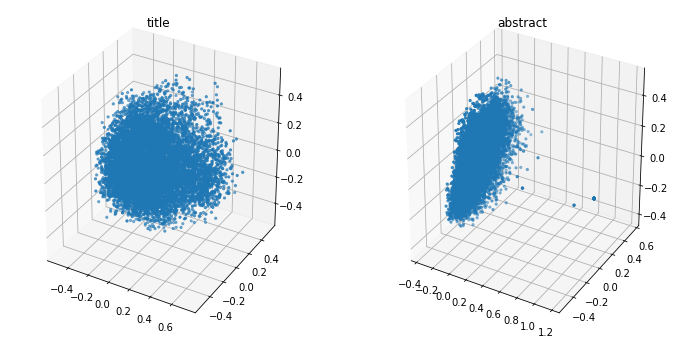

In [ ]:
titles_emb_norm = df.title_embeddings_norm.tolist()
abstracts_emb_norm = df.abstract_embeddings_norm.tolist()

# linear
pca = PCA(n_components=3)

# norm
pca_title_embeddings_norm = pca.fit_transform(titles_emb_norm)
pca_abstract_embeddings_norm = pca.fit_transform(abstracts_emb_norm)

# plot
titles = ['title','abstract','title normalize','abstract normalize']
vecs = [pca_title_embeddings_norm,pca_abstract_embeddings_norm]

fig = plt.figure(1, figsize=(25, 6))

for i,(t,pca) in enumerate(zip(titles,vecs)):
  ax = fig.add_subplot(1, 4, i+1, projection='3d')
  ax.scatter(pca[:,0], pca[:,1], pca[:,2],marker='.')
  ax.set_title(t)
  fig.show();

Clustering:

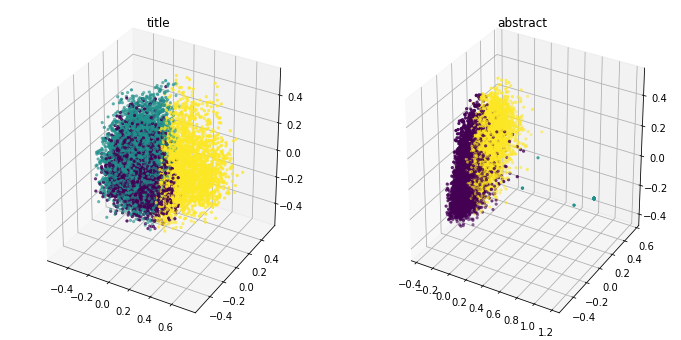

In [ ]:
K = 10

kmeans = KMeans(n_clusters=3, init='random',n_init=10, max_iter=300,tol=1e-04, random_state=0)

fig = plt.figure(1, figsize=(25, 6))
for i,(t,pca) in enumerate(zip(titles,vecs)):
  kmeans.fit(pca)
  labels = kmeans.labels_

  ax = fig.add_subplot(1, 4, i+1, projection='3d')
  ax.scatter(pca[:,0], pca[:,1], pca[:,2],marker='.',c=labels)
  ax.set_title(t)
fig.show()

Find the Right K and the right representation:

In [ ]:
K = 20
titles = ['title normalize','abstract normalize']
vecs = [pca_title_embeddings_norm,pca_abstract_embeddings_norm]

scores = pd.DataFrame(columns=['title','k','inertia','silhouette','labels'])

for k in range(2,K):
  kmeans = KMeans(n_clusters=k,max_iter=300,tol=1e-04,init='random',random_state=0)
  for i in range(len(titles)):
    kmeans.fit(vecs[i])
    
    title = titles[i]
    labels = kmeans.labels_  
    inertia = kmeans.inertia_
    silhouette = silhouette_score(vecs[i], labels)

    scores.loc[len(scores)] = [title,k,inertia,silhouette,labels]

Abstract:

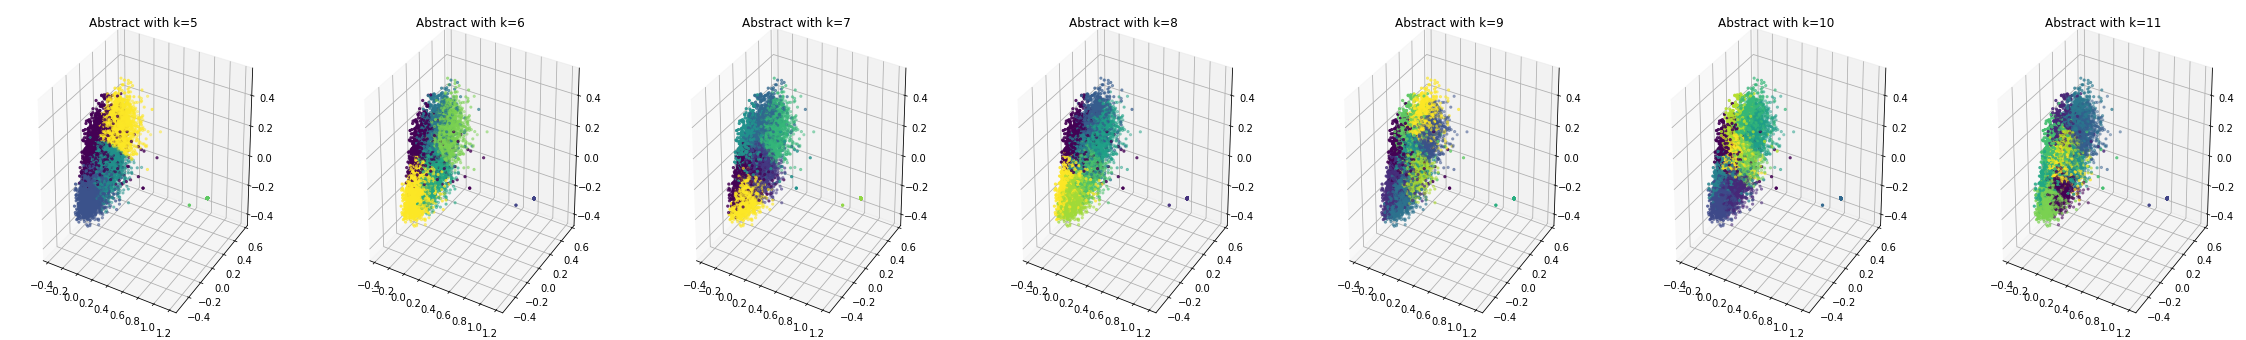

In [ ]:
fig = plt.figure(1, figsize=(40, 6))

X = pca_abstract_embeddings_norm
Ks = scores[scores.title=='abstract normalize'].k.tolist()[3:10]
labels = scores[scores.title=='abstract normalize'].labels.tolist()[3:10]

for i,(k,l) in enumerate(zip(Ks,labels)):
  ax = fig.add_subplot(1, 7, i+1, projection='3d')
  ax.scatter(X[:,0], X[:,1], X[:,2],marker='.',c=l)
  ax.set_title('Abstract with k=' + str(k))
fig.show()

Inertia:

''

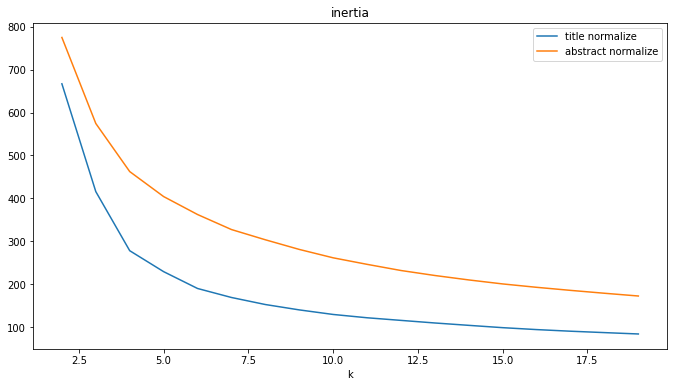

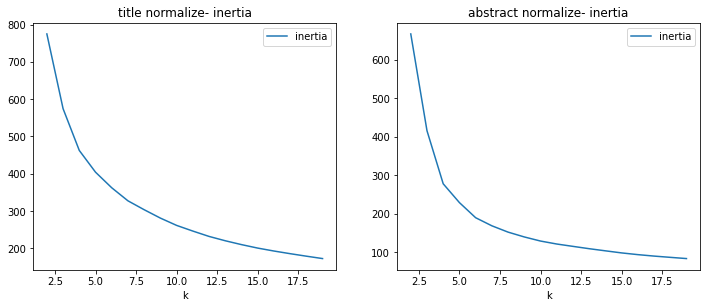

In [ ]:
plt.figure(figsize=(25, 6)) 

ty = ['inertia']#,'silhouette']

for i,t in enumerate(ty):
  plt.subplot(1,2,i+1)
  scores.groupby(by='title').plot(x='k',y=t,ax=plt.gca())
  plt.legend(scores.title.tolist())
  plt.title(t)

plt.figure(figsize=(25, 10)) 

for i,t in enumerate(titles):
  # for i,t in enumerate(['inertia','silhouette']):
    plt.subplot(2,4,i+1)
    scores[scores.title==t].plot(x='k',y='inertia',ax=plt.gca())
    plt.title(t + '- inertia')

;

Due to the Elbow method - We can see that the best Ks are in the range of [7-12] for all representations. And in that range, we choose k=7.

<br><br>

Explain the clusters:   
We will sample titles form the K clusters to understand and characterize the essence of each group.

Text(0.5, 1.0, 'Element count per group')

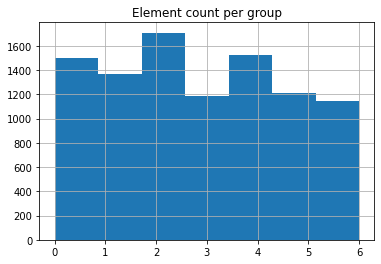

In [ ]:
k = 7
labels = scores[(scores.title=='title normalize') & (scores.k==k)].labels.values[0]

df['label'] = scores[(scores.title=='title normalize') & (scores.k==k)].labels.values[0]
groups = df[['title','label']]

groups.label.hist(bins=k);
plt.title('Element count per group')

Groups Popular words:

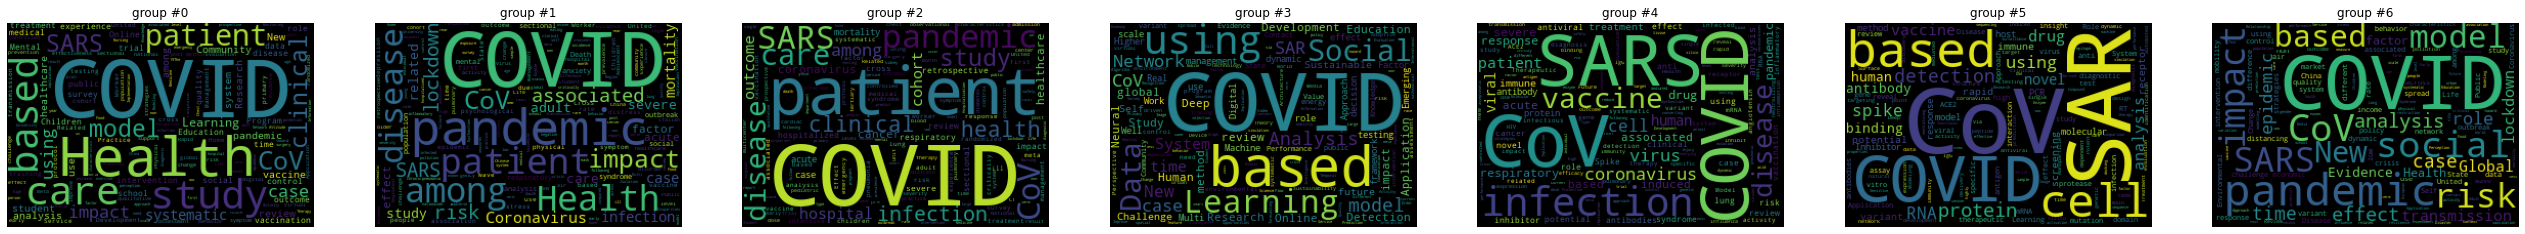

In [ ]:
def plot_cloud(list_text,plottitle='',sub_i=0):
    text = "".join(list_text)  
    wordcloud = WordCloud(width = 300, height = 200, collocations=False, stopwords = STOPWORDS).generate(text)
    
    plt.subplot(1,7,sub_i+1)
    plt.imshow(wordcloud) 
    plt.axis("off");
    plt.title(plottitle)


plt.figure(figsize=(45, 10)) 
for g in np.unique(groups.label):
  plot_cloud(groups.title[groups.label==g].tolist(),plottitle='group #'+str(g),sub_i=g)

It seems some groups have more focus on media(Online,Digital,Social),
But the other seems to be variations of health(Risks,Clinical,Infection). However not much of a difference.... Let's try TF-IDF!

<br>

the popular word are not surprising, but due to the huge amount of use.. lets try a different aproach:

In [ ]:
def get_tfidf_top_features(group_i,n_top=15,by='title',no_features=100):

  # get relevant group text
  documents = groups[groups.label==group_i][by].to_list()

  # vectorize
  tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
  
  # learn & predict
  tfidf = tfidf_vectorizer.fit_transform(documents)

  # sort by importance
  importance = np.argsort(np.asarray(tfidf.sum(axis=0)).ravel())[::-1]

  # get words
  tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names())

  return tfidf_feature_names[importance[:n_top]]

def remove_element(some_list,things):
  for thing in things:
    if thing in some_list: 
      some_list.remove(thing)


def get_groups_pop_words(groups,n_top=15,by='title'):
  gs = {}
  
  for g in np.unique(groups.label):
    # sort by abc just to make things more clear
    gs[g] = sorted(get_tfidf_top_features(group_i=g,n_top=n_top,by=by).tolist())

    # just to make the difference more clear
    remove_element(gs[g],['covid','19','sars','cov','pandemic','analysis','based','abstract','2020','research', 'results','covid-','covid-19','19.']) 
  return gs

gs = get_groups_pop_words(groups,by='title')
for g in gs:
  print('group #' + str(g) +' : ',end='\t')
  print(gs[g],end='\n\n')

group #0 : 	['care', 'clinical', 'health', 'impact', 'patients', 'review', 'study', 'using']

group #1 : 	['associated', 'disease', 'health', 'impact', 'infection', 'lockdown', 'mortality', 'patients', 'risk', 'study']

group #2 : 	['care', 'clinical', 'disease', 'health', 'hospital', 'impact', 'infection', 'patient', 'patients', 'study']

group #3 : 	['approach', 'data', 'future', 'learning', 'model', 'social', 'study', 'using']

group #4 : 	['coronavirus', 'disease', 'human', 'infection', 'patients', 'study', 'vaccine', 'viral', 'virus']

group #5 : 	['antibody', 'cell', 'detection', 'human', 'novel', 'protein', 'rna', 'spike', 'using']

group #6 : 	['global', 'impact', 'model', 'new', 'risk', 'role', 'social', 'study']



AMAZING!  
If feels like each group has it own "focus"...  

- Group #0 - Medical  
- Group #1 - Research & study  
- Group #2 - Hospitals  
- Group #3 - Social aspect  
- Group #4 - Diseases  
- Group #5 - Very Medical  
- Group #6 - Social aspect  

(should considere lower K)

<br><br><br>
Let's do the same for abstract. And try to get better results!

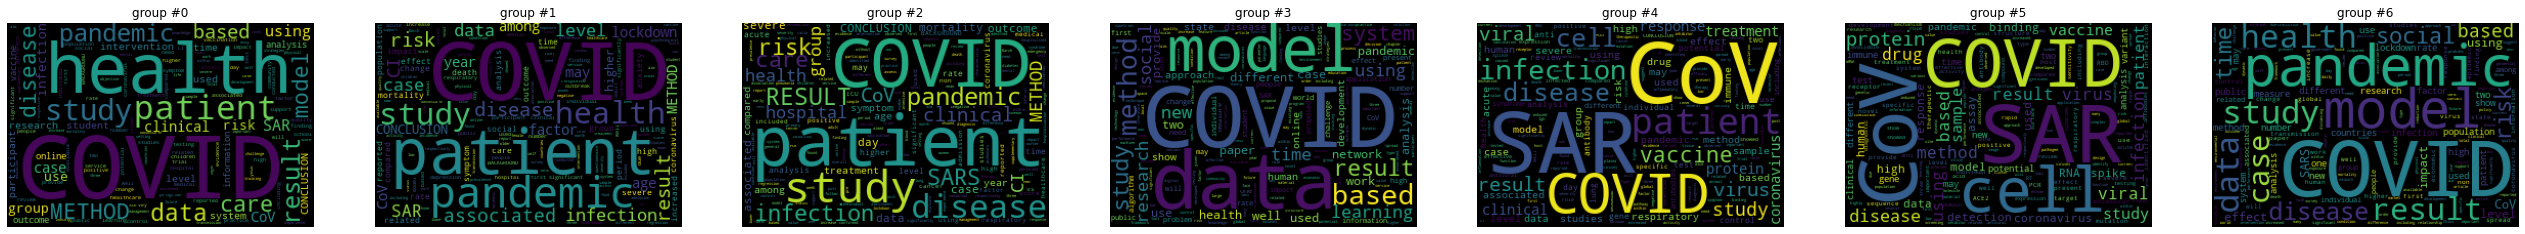

In [ ]:
groups = df[['abstract','label']]

plt.figure(figsize=(45, 10)) 
for g in np.unique(groups.label):
  plot_cloud(groups.abstract[groups.label==g].tolist(),plottitle='group #'+str(g),sub_i=g)

In [ ]:
gs = get_groups_pop_words(groups,20,'abstract')

for g in gs:
  print('group #' + str(g) +' : ',end='\t')
  print(gs[g],end='\n\n')

group #0 : 	['care', 'clinical', 'data', 'disease', 'health', 'model', 'patients', 'risk', 'students', 'study', 'use', 'using']

group #1 : 	['95', 'associated', 'ci', 'data', 'disease', 'health', 'infection', 'lockdown', 'mortality', 'patients', 'risk', 'social', 'study']

group #2 : 	['95', 'care', 'ci', 'clinical', 'disease', 'health', 'hospital', 'infection', 'mortality', 'patient', 'patients', 'risk', 'study', 'treatment']

group #3 : 	['approach', 'data', 'health', 'learning', 'model', 'new', 'paper', 'social', 'study', 'time', 'use', 'used', 'using']

group #4 : 	['cell', 'cells', 'clinical', 'coronavirus', 'disease', 'infection', 'patients', 'respiratory', 'severe', 'study', 'treatment', 'vaccine', 'viral', 'virus']

group #5 : 	['binding', 'cell', 'cells', 'data', 'detection', 'disease', 'high', 'protein', 'rna', 'study', 'used', 'using', 'viral', 'virus']

group #6 : 	['cases', 'data', 'different', 'disease', 'health', 'model', 'risk', 'social', 'study', 'time', 'using']



Although the groups(clusters) are still the same, there is somewhat of a different feeling.  
Howerver, not for from our explanation with the titles...

- Group #0 - .. 
- Group #1 - Social aspect
- Group #2 - ..
- Group #3 - Research & study
- Group #4 - Diseases & Treatment
- Group #5 - Very Medical   
- Group #6 - Epidemic

<br><br><br>
<br><br><br>
<br><br><br>

#### Evaluation
b. Suggest a (good!) evaluation method, in order to evaluate the performance
your model from part 1 and report the results you obtained

<br>


```
We will use Augmentation!
Our augmentation will be based on Gensim's Word2Vec.
We'll also consider an augmentation based on translation.
```



get model's weights:

In [ ]:
!wget "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-06-20 01:32:56--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.164.165
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.164.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz.1’

GoogleNews-vectors- 100%[===================>]   1.53G  33.1MB/s    in 47s     

2021-06-20 01:33:43 (33.5 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz.1’ saved [1647046227/1647046227]



load weights to model:

In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

Create an augment model:

In [ ]:
w2v = Word2vec(model=model)

Check for similarity on the same title:

In [ ]:
t = df.sample().title.values[0]
t_augment = w2v.augment(t)

t_sim = article_similarity_score(t,t_augment)

print('original title >>> ', t)
print('augment title  >>> ',t_augment)
print('titles similarity: ', t_sim)

original title >>>  Synthetic protein antigens for COVID-19 diagnostics
augment title  >>>  synthetic protein epitope forthe covid-19 diagnostic_assays
titles similarity:  0.93439543


Check for similarity on the same abstract:

In [ ]:
t = df.sample().abstract.values[0]
t_augment = w2v.augment(t)

t_sim = article_similarity_score(t,t_augment)

print('original title >>> ', t)
print('augment title  >>> ',t_augment)
print('titles similarity: ', t_sim)

original title >>>  BACKGROUND: In early 2020, Ecuador reported one of the highest surges of per capita deaths across the globe. METHODS: We collected a comprehensive dataset containing individual death records between 2015 and 2020 from the Ecuadorian National Institute of Statistics and Census and the Ecuadorian Ministry of Government. We computed the number of excess deaths across time, geographical locations and demographic groups using Poisson regression methods. RESULTS: Between January 1(st) and September 23(rd), 2020, the number of excess deaths in Ecuador is 36,402 (95% CI: 35,762–36,827) or 208 per 10(5) population, which is 171% of the expected deaths in that period in a typical year. Only 20% of the excess deaths are attributable to confirmed COVID-19 deaths. Strikingly, in provinces that were most affected by COVID-19, such as Guayas and Santa Elena, the all-cause deaths are more than double the expected number of deaths that would have occurred in a normal year. The exten

Looks promising! Let's check it out for the whole dataset:

due to the amount of time, we'll do this only on the titles, and in parallel...

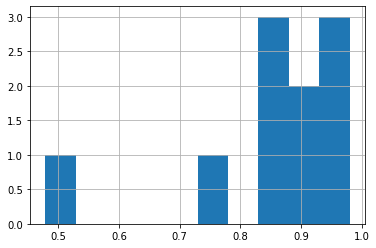

In [ ]:
titles_score = df.sample(10).title.apply(lambda t: article_similarity_score(t,w2v.augment(t))  )
titles_score.hist()


mean score:  0.8857441383600235


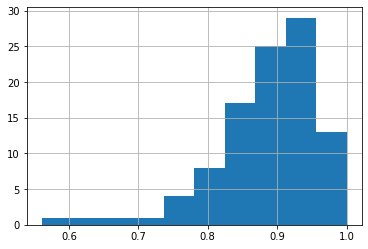

In [ ]:
def parallel_augment_similarity(t):
    return article_similarity_score(t,w2v.augment(t))

n_parallel_samples = 100
mapply.init(n_workers=-1)
titles_score = df.sample(n_parallel_samples).title.mapply(parallel_augment_similarity)
print('mean score: ', np.mean(titles_score))
titles_score.hist();

GREAT! While using augmentation on the titles, and then perform our similarity - we get very good results! 

This time we'll we translation based augmentations:  
due to this being much faster, we'll do this on the abstract.

In [ ]:
source_language = "en"
target_language = "fr" 
translator = Translate(src=source_language, to=target_language)

def parallel_augment_translate_similarity(a):
    return article_similarity_score(a,translator.augment(a))

n_parallel_samples = 100
mapply.init(n_workers=-1)
abstracts_score = df.sample(n_parallel_samples).abstract.mapply(parallel_augment_translate_similarity)
print('mean score: ', np.mean(abstracts_score))
abstracts_score.hist();

HTTPError: ignored

Since we exceed the rate limit, it started to return HTTP 429 too many requests error.

An additinal ay will be to check the similarity "by hand":

In [ ]:
df.sample()

,title,cord_uid,abstract,body_text,language_title,title_embeddings,abstract_embeddings,title_embeddings_norm,abstract_embeddings_norm
6122,Incorporating Virtues: A Speech Act Approach to Understanding how Virtues Can Work in Business,629793jt,One of the key debates about applying virtue ethics to business is whether or not the aims and values of a business actually prevent the exercise of virtues. Some of the more interesting disagreement in this debate has arisen amongst proponents o...,By a practice I am going to mean any coherent and complex form of socially established cooperative human activity through which goods internal to that form of activity are realized in the course of trying to achieve those standards of excellence ...,en,"[-0.034224096685647964, 1.050662636756897, 1.0701130628585815, -0.28604164719581604, 0.3111473023891449, -0.17125415802001953, 0.745607316493988, -0.6423193216323853, 0.21387146413326263, -0.14075767993927002, -0.25748130679130554, 1.097115516662...","[0.12962044775485992, 0.7862478494644165, 0.5150471925735474, -0.2553897500038147, 0.09241729974746704, 0.2376898229122162, 1.0774363279342651, -0.5894928574562073, 0.4910248816013336, -0.042453423142433167, 0.20719337463378906, 1.380214810371399...","[-0.0021043469939697745, 0.06460239934580682, 0.0657983533566449, -0.017587926014687214, 0.01913160474266013, -0.010529954258380152, 0.045845374081238156, -0.039494475078801446, 0.013150376963301425, -0.008654808434507976, -0.01583182805163451, 0...","[0.008852064592526271, 0.053694589624906884, 0.03517370211128141, -0.01744112601414881, 0.0063113800407371854, 0.016232359182898906, 0.07358048930093158, -0.04025775980116979, 0.033533165821899434, -0.0028992373529011972, 0.014149689861205008, 0...."


In [ ]:
df_results = pd.DataFrame(columns=['score','title'])

arrs = df.title_embeddings_norm.apply(np.array)
arrs_sample = arrs.sample()

print('original title: ', df.loc[arrs_sample.index].title.values[0] )

sample_to_title_similarity = cosine_similarity(arrs_sample.tolist(),arrs.tolist())
sorted_inds = np.argsort(sample_to_title_similarity)[0][::-1]

df_results['score'] = sample_to_title_similarity[0][sorted_inds[:10]]
df_results['title'] = df["title"].iloc[sorted_inds[:10]].values
df_results

original title:  Inertial Microfluidics Enabling Clinical Research


,score,title
0,1.000000,Inertial Microfluidics Enabling Clinical Research
1,0.785904,Myocardial Work: Methodology and Clinical Applications
2,0.768198,Roles of Microglial Ion Channel in Neurodegenerative Diseases
3,0.767849,A Data-driven Framework for Learning and Visualizing Characteristics of Thrombotic Event Phenotypes from Clinical Texts
4,0.765363,Application of nanotechnology in drug delivery systems for respiratory diseases
5,0.757984,Embedding clinical trials within routine health‐care delivery: Challenges and opportunities
6,0.753742,Evaluating Dissemination and Implementation Strategies to Develop Clinical Software
7,0.753719,Short-Pulse Lasers: A Versatile Tool in Creating Novel Nano-/Micro-Structures and Compositional Analysis for Healthcare and Wellbeing Challenges
8,0.752917,Telehealth in Multiple Sclerosis Clinical Care and Research
9,0.751083,Optimization of the ASPIRE Spherical Parallel Rehabilitation Robot Based on Its Clinical Evaluation


As we can see, the original title get a perfect score - due to it being similar to itself.

The closest 9 other titles looks kina similar.
Although, this is a domain expert job, we can "feel" the similarity between these titles. 

<br><br><br><br>

Thanks For Reading... :))